<a href="https://colab.research.google.com/github/dominiquebuford/DL-individual/blob/main/DL_individual_naiveApproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dominiquebuford/DL-individual.git

Cloning into 'DL-individual'...
remote: Enumerating objects: 897, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 897 (delta 16), reused 27 (delta 9), pack-reused 855
Receiving objects: 100% (897/897), 436.93 MiB | 25.99 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (856/856), done.


In [2]:
import numpy as np
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch, detectron2

from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-c0vt04z7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-c0vt04z7
  Resolved https://github.com/facebookresearch/detectron2.git to commit b7c7f4ba82192ff06f2bbb162b9f67b00ea55867
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6150091 sha256=9f4ca6f716b16889ef354c2d3a5a1

In [3]:

def custom_mapper(dataset_dict):
  image = utils.read_image(dataset_dict["file_name"], format="BGR")
  transform_list = [
      T.Resize((800,600)),
      T.RandomLighting(0.5),
      T.RandomContrast(0.3, 0.5),  # Adjust the contrast range for dim lighting
      T.RandomSaturation(0.1, 0.3),
      T.RandomBrightness(0.1, 0.2),
  ]
  image, transforms = T.apply_transform_gens(transform_list, image)
  dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

  annos = [
      utils.transform_instance_annotations(obj, transforms, image.shape[:2])
      for obj in dataset_dict.pop("annotations")
      if obj.get("iscrowd", 0) == 0
  ]
  instances = utils.annotations_to_instances(annos, image.shape[:2])
  dataset_dict["instances"] = utils.filter_empty_instances(instances)
  return dataset_dict

In [15]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_train_loader, build_detection_test_loader

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

  @classmethod
  def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

  @classmethod
  def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=custom_mapper)

In [5]:
register_coco_instances("my_dataset_train", {}, "DL-individual/data/train_annotations.json", "DL-individual/data/train")
register_coco_instances("my_dataset_val", {}, "DL-individual/data/val_annotations.json", "DL-individual/data/val")

In [6]:
cfg = get_cfg() # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.1  # pick a good LR
cfg.SOLVER.MAX_ITER = 800
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   #128   # faster (default: 512)
#cfg.SOLVER.STEPS = (200, 500)
cfg.SOLVER.GAMMA = 0.005
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((16, 1), dtype=float).tolist()

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # hand
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 16

In [17]:
keypoint_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']
keypoint_flip_map = [
    ('a', 'f'),  # 'r ankle' and 'l ankle'
    ('b', 'e'),  # 'r knee' and 'l knee'
    ('c', 'd'),  # 'r hip' and 'l hip'
    ('j', 'i'),  # 'head top' and 'upper neck'
    ('k', 'h'),  # 'r wrist' and 'l wrist'
    ('l', 'g'),  # 'r elbow' and 'l elbow'
    ('m', 'p'),  # 'r shoulder' and 'l shoulder'
]
MetadataCatalog.get("my_dataset_val").thing_classes = ["person"]
MetadataCatalog.get("my_dataset_val").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("my_dataset_val").keypoint_names = keypoint_names
MetadataCatalog.get("my_dataset_val").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("my_dataset_val").evaluator_type="coco"

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader

# Build the test loader using your custom mapper
trainer = CocoTrainer(cfg)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
val_loader = trainer.build_test_loader(cfg, "my_dataset_val")
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
results = inference_on_dataset(trainer.model, val_loader, evaluator)
predictor = DefaultPredictor(cfg)

[04/06 20:56:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.keypoint_head.score_lowres.{bias, weight}


[04/06 21:02:15 d2.data.datasets.coco]: Loaded 169 images in COCO format from DL-individual/data/val_annotations.json


<ipython-input-19-bbdc767f72bf>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(), plt.imshow(im), plt.axis('off');


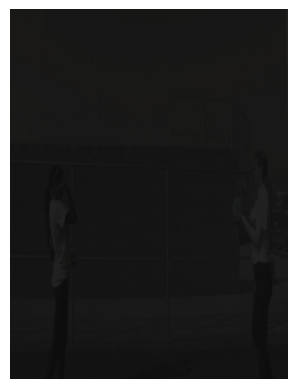

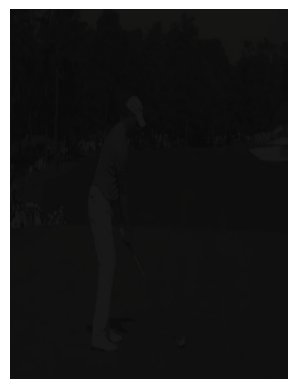

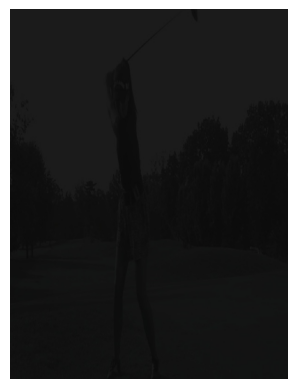

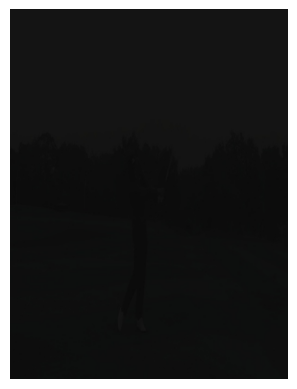

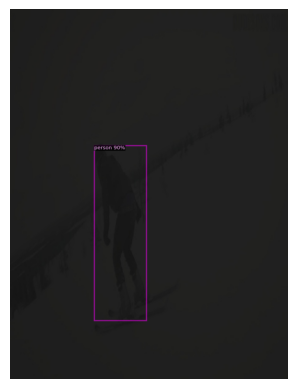

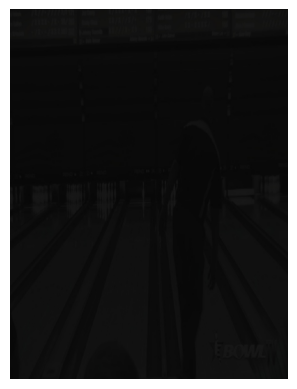

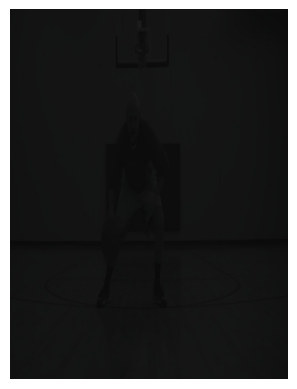

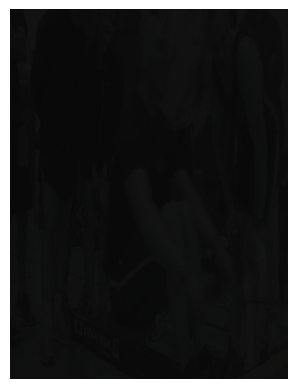

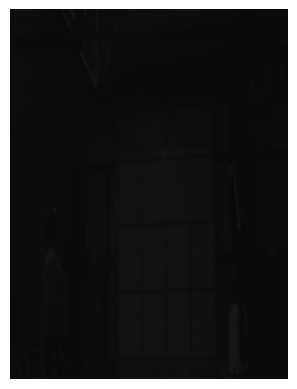

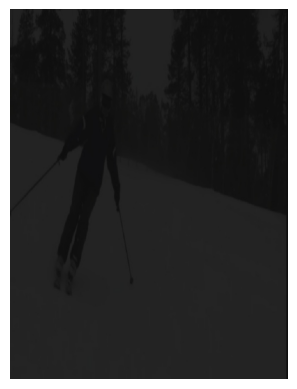

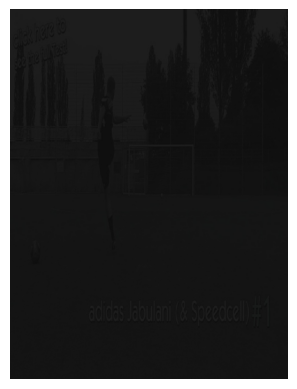

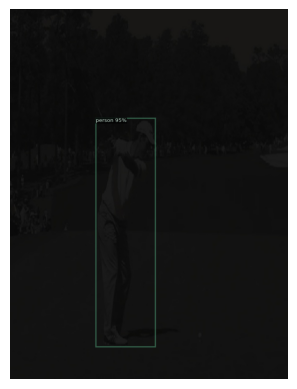

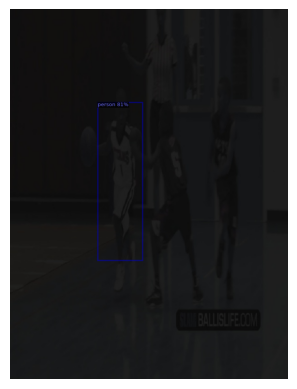

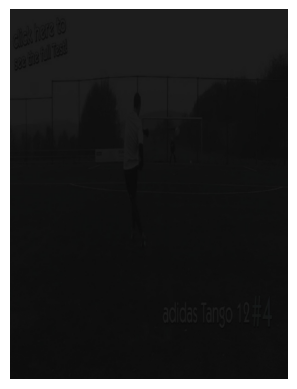

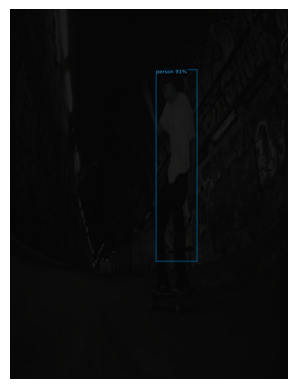

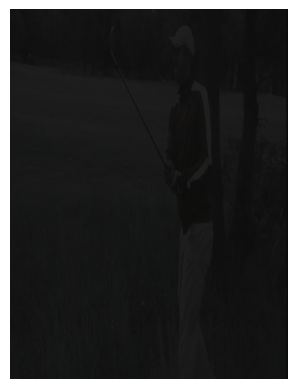

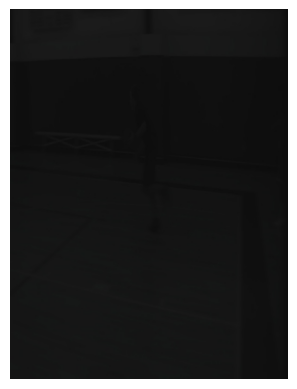

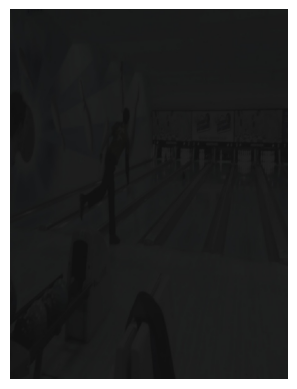

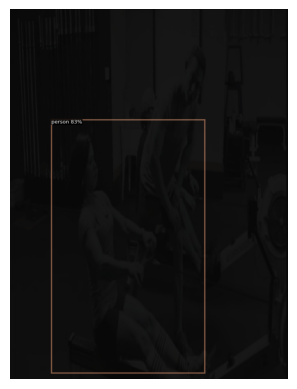

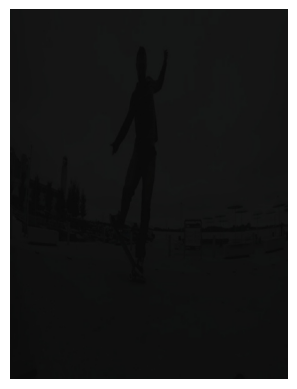

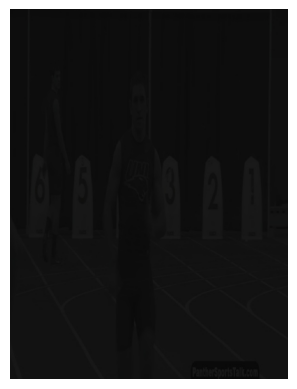

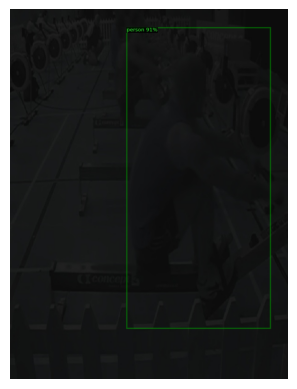

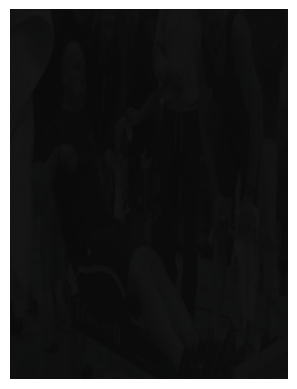

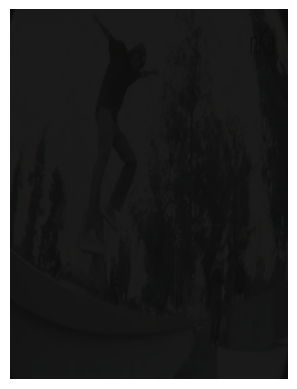

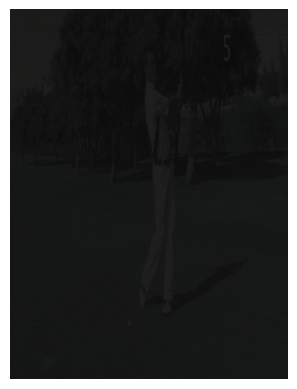

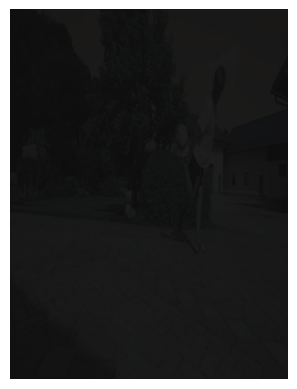

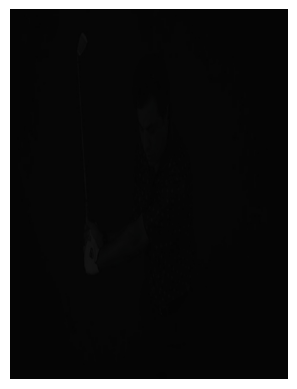

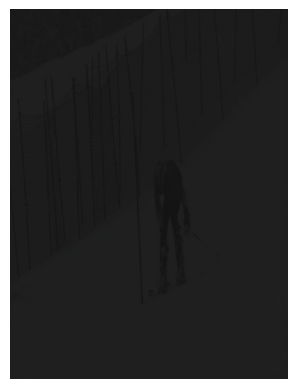

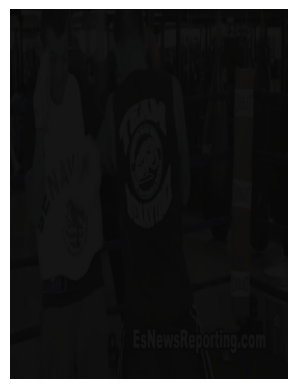

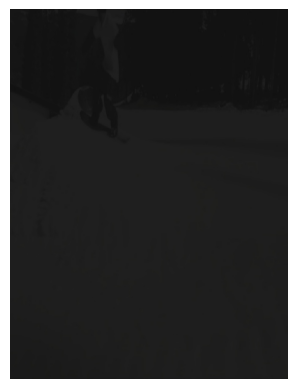

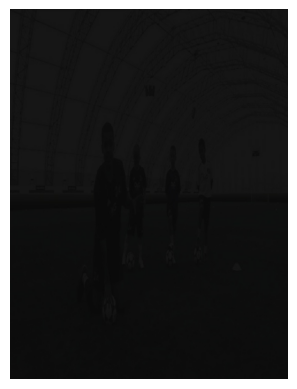

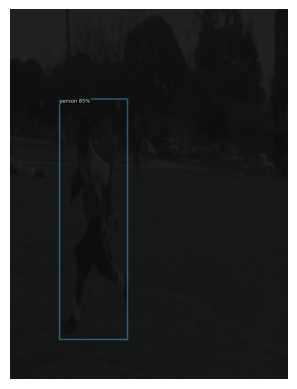

Error in callback <function flush_figures at 0x7d0a010143a0> (for post_execute):


KeyboardInterrupt: 

In [19]:
import random
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt
dataset_dicts = DatasetCatalog.get("my_dataset_val")


import os
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');
# Define a directory to save the augmented images
output_dir = "augmented_images"
os.makedirs(output_dir, exist_ok=True)

# Loop over your dataset and apply data augmentation
for idx, dataset_dict in enumerate(dataset_dicts):
    # Apply your custom mapper function to augment the image
    augmented_dict = custom_mapper(dataset_dict)

    # Get the augmented image from the dataset dictionary
    augmented_image = augmented_dict["image"]
        # Convert the augmented image from tensor to numpy array
    augmented_image = augmented_image.permute(1, 2, 0).numpy()

    # Convert the augmented image from BGR to RGB (if necessary)
    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)

    # Save the augmented image to disk
    output_path = os.path.join(output_dir, f"augmented_image_{idx}.jpg")
    cv2.imwrite(output_path, augmented_image)

    finalImage = cv2.imread(output_path)

    predictions = predictor(finalImage)


    # Visualize the predictions on the augmented image
    v = Visualizer(finalImage[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(predictions["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2.waitKey(0)


# Close all OpenCV windows
cv2.destroyAllWindows()